In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cvxpy as cvx
#import networkx as nx
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from subprocess import call
from IPython.display import SVG
from graphviz import Source
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

## 1. Loading the Data
This is the dataset that contains the 2016, 2017 and 2018 seasons.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/Data Analytics/College_Football_Prediction_Modelling'
df = pd.read_csv("{}/16_17_18_data.csv".format(data_dir))
df.head()

Mounted at /content/drive


,Date,Week,T1 VH,T1 Ranked,T1 Name,T1 ML,T1 Open,T1 Close,T1 Move,T1 Win %,...,T2 Cover %,T2 Over %,O/U Open,O/U Close,O/U Move,T1 Final,T2 Final,O/U,ML,Cover
0,826,0,0.5,0,California,-2000,-22.0,-21.5,0.5,0.0,...,0.0,0.0,63.0,66.0,3.0,51,31,1,1,0
1,901,1,0.0,0,Indiana,-380,-4.0,-10.0,-6.0,0.0,...,0.0,0.0,61.0,64.0,3.0,34,13,0,1,1
2,901,1,1.0,0,WakeForest,-600,-17.0,-14.5,2.5,0.0,...,0.0,0.0,47.0,43.0,-4.0,7,3,0,1,0
3,901,1,1.0,0,WesternKentucky,-1050,-16.5,-19.5,-3.0,0.0,...,0.0,0.0,60.0,65.0,5.0,46,14,0,1,1
4,901,1,1.0,0,Vanderbilt,-220,-2.5,-5.0,-2.5,0.0,...,0.0,0.0,46.5,40.5,-6.0,10,13,0,0,0


In [ ]:
#Viewing all columns to make sure nothing is missing
df.columns

Index(['Date', 'Week', 'T1 VH', 'T1 Ranked', 'T1 Name', 'T1 ML', 'T1 Open',
       'T1 Close', 'T1 Move', 'T1 Win %', 'T1 Cover %', 'T1 Over %', 'T2 VH',
       'T2 Ranked', 'T2 Name', 'T2 ML', 'T2 Open', 'T2 Close', 'T2 Move',
       'T2 Win %', 'T2 Cover %', 'T2 Over %', 'O/U Open', 'O/U Close',
       'O/U Move', 'T1 Final ', 'T2 Final', 'O/U', 'ML', 'Cover'],
      dtype='object')

In [ ]:
#Drop columns that contain data on bets
df = df.drop(['T1 Final ', 'T2 Final', 'O/U', 'ML', 'T1 Name', 'T1 Move', 'T2 Name', 'T2 Move', 'Date', 'O/U Open', 'O/U Close', 'O/U Move'], axis=1)

#Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(df.drop('Cover',1), df['Cover'], test_size=0.30, random_state=5) ### Change Vandal

<ipython-input-5-fc12ab9693b3>:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_train, x_test, y_train, y_test = train_test_split(df.drop('Cover',1), df['Cover'], test_size=0.30, random_state=5) ### Change Vandal


## 2. CART Model
We first start by creating a CART model to understand the performance of a single decision tree and establish a baseline for prediction accuracy. It also gives us a baseline in terms of accuracy and identify whether a Random Forest would provide a significant improvement.

The score of this model over training data is 0.922 and 0.528 over the testing data


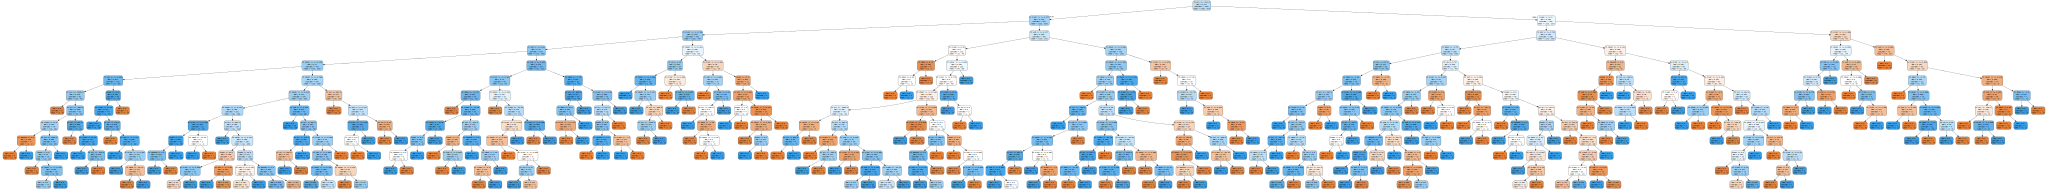

In [ ]:
# Train the CART model
cart_model = DecisionTreeClassifier(random_state=3,max_depth=12)
cart_model.fit(x_train, y_train)
train_score = cart_model.score(x_train, y_train)
test_score = cart_model.score(x_test, y_test)

# Print out summary of model performance
print('The score of this model over training data is {:.3f} and {:.3f} over the testing data'.format(train_score, test_score))

# Visualize the decision tree
cart_graph = Source(export_graphviz(cart_model,
                   feature_names = x_train.columns,
                   rounded = True, proportion = False,
                  filled = True))
SVG(cart_graph.pipe(format='svg'))

## Random Forest
After getting the CART model scores for the training and testing data, we see that overfitting is occuring as the model performs significantly better on the training data compared to the testing data (too large of a gap).

Although it is not guranteed, Random Forest models tend to be less prone to overfitting. We will also add further adjustments and optimization to our model to achieve desirable results. We will have 50 estimators in our random forest, as we believe that any more will not improve accuracy, giving us 50 different probabilities that a bet will win.

In [ ]:
def fit_and_score_model(mdl, x_train, x_test, y_train, y_test, random_state=0):
    """
    This function will fit and score the input mdl to the x_train and y_train
    data, and score the mdl on y_train and y_test. To ensure results are
    reproducible we can also set a random state.
    """

    # Fit an arbitrary model
    mdl.fit(x_train, y_train)

    # Calculate the score of the model on training and testing data
    train_score = mdl.score(x_train, y_train)
    test_score = mdl.score(x_test, y_test)

    # Print scores to terminal
    print('the accuracy on the: \n\t training data is {}'.format(round(train_score,3)))
    print('\t testing data is {}'.format(round(test_score, 3)))

    return train_score, test_score


In [ ]:
#Run the Random Forest model
clf= RandomForestClassifier(n_estimators=50,max_features=0.2,max_depth=6)
clf.fit(x_train,y_train)
train_score, test_score = fit_and_score_model(clf, x_train, x_test, y_train, y_test)

the accuracy on the: 
	 training data is 0.719
	 testing data is 0.583


Although the gap has been somewhat reduced compared to the CART model, there is still a significant difference between the training and testing accuracy. We will tune the model by performing cross validation technique and see what is the best maximum depth of the trees in terms of the score.

In [ ]:
from sklearn.model_selection import cross_validate

# Initailize cross validation score DataFrame
depth_lb = 1
depth_ub =15
cv_scores = pd.Series(index=np.arange(depth_lb, depth_ub))
test = pd.Series(index=np.arange(depth_lb, depth_ub))

for max_depth in range(depth_lb, depth_ub):
  print(max_depth)
  average = 0
  for i in range(5):
    clf= RandomForestClassifier(n_estimators=50,max_features=0.2,max_depth=max_depth)
    clf.fit(x_train,y_train)
    train_score, test_score = fit_and_score_model(clf, x_train, x_test, y_train, y_test)
    average += test_score
  # Initialize the model
  rf_cv1_model = RandomForestClassifier(random_state = 0, max_depth = max_depth,
                          n_estimators = 50, max_features = 0.2)

  test.loc[max_depth] = average/5
  # Run cross validation to get measure of out-of-sample error
  example_cv_results = cross_validate(rf_cv1_model, x_train, y_train, cv=5)

  # Record the average out-of-sample error
  cv_scores.loc[max_depth] = example_cv_results['test_score'].mean()

1


<ipython-input-9-2bdbc1ae8b92>:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  cv_scores = pd.Series(index=np.arange(depth_lb, depth_ub))
<ipython-input-9-2bdbc1ae8b92>:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  test = pd.Series(index=np.arange(depth_lb, depth_ub))


the accuracy on the: 
	 training data is 0.606
	 testing data is 0.582
the accuracy on the: 
	 training data is 0.606
	 testing data is 0.582
the accuracy on the: 
	 training data is 0.606
	 testing data is 0.582
the accuracy on the: 
	 training data is 0.606
	 testing data is 0.582
the accuracy on the: 
	 training data is 0.606
	 testing data is 0.582
2
the accuracy on the: 
	 training data is 0.621
	 testing data is 0.58
the accuracy on the: 
	 training data is 0.631
	 testing data is 0.585
the accuracy on the: 
	 training data is 0.618
	 testing data is 0.578
the accuracy on the: 
	 training data is 0.621
	 testing data is 0.577
the accuracy on the: 
	 training data is 0.62
	 testing data is 0.578
3
the accuracy on the: 
	 training data is 0.631
	 testing data is 0.583
the accuracy on the: 
	 training data is 0.642
	 testing data is 0.58
the accuracy on the: 
	 training data is 0.642
	 testing data is 0.58
the accuracy on the: 
	 training data is 0.634
	 testing data is 0.583
the ac

Text(0.5, 0, 'max_depth')

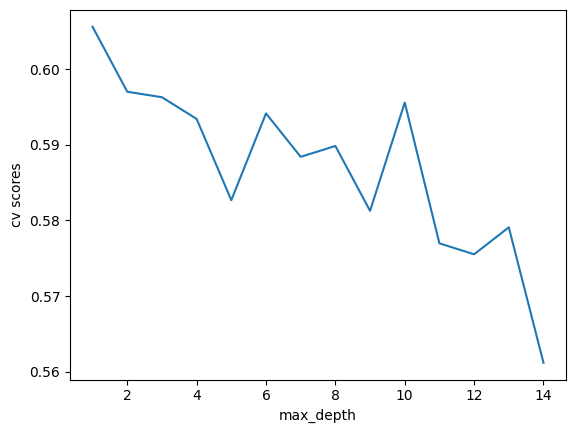

In [ ]:
plt.plot(cv_scores)
plt.ylabel("cv scores")
plt.xlabel("max_depth")

Based on the results for each max depth and the graph with the scores, we see a max depth of 1 gives the highest score. However we cannot set the max depth to 1 since the tree comes down to a collection of decision stumps (trees with one split) and decision stumps are unlikely to capture meaningful patterns in most real-world datasets. We need to have a reasonable size for the max depth while minimizing the chances of the model being overfitted. Looking at when the max depth is 10, we see the score is pretty high. However, we see that there is a big gap between the testing and training scores, which suggest signs of overfitting. The best max depth seems to still be 6. Even though the gap between the training and testing scores is high, it is still relatively smaller than the other depths, and it has a solid score.  

## Get Variances
We will now calculate the variance of predictions made by individual decision trees in a Random Forest model for each data point in the testing dataset.

In [ ]:
#Initialize an empty list to store variances
variances = []

#Loop through the data points in the testing dataset
for data_point_index in list(x_test.index.values):
    #Initialize an empty list to store predictions from individual decision trees
    individual_tree_predictions = []

    #Initialize a variable to calculate the sum of individual tree predictions
    prediction_sum = 0

    #Iterate through the first 50 decision trees in the Random Forest
    for tree_index in range(0, 49):
        #Make a prediction using the current decision tree for the current data point
        tree_prediction = clf.estimators_[tree_index].predict([x_test.loc[data_point_index]])

        #Append the prediction to the list of individual tree predictions
        individual_tree_predictions.append(tree_prediction)

        #Add the prediction to the sum
        prediction_sum += tree_prediction

    #Calculate the mean prediction across all 50 decision trees
    mean_prediction = prediction_sum / 50

    #Initialize a variable to calculate the variance
    variance = 0

    #Iterate through the first 50 decision trees again
    for tree_index in range(0, 49):
        #Calculate the squared difference between the current tree's prediction
        #and the mean prediction, and add it to the variance
        squared_difference = (individual_tree_predictions[tree_index] - mean_prediction) ** 2
        variance += squared_difference

    #Calculate the final variance by dividing by the number of trees minus 1
    variance /= 50

    #Append the calculated variance to the list of variances
    variances.append(variance)


Judging quickly, we see that the variances ranges roughly from 0.1 to 0.25.

In [ ]:
print(variances)

[array([0.240128]), array([0.2002]), array([0.191232]), array([0.242528]), array([0.208352]), array([0.240128]), array([0.245]), array([0.170848]), array([0.240128]), array([0.245]), array([0.240128]), array([0.244192]), array([0.120288]), array([0.208352]), array([0.2328]), array([0.134152]), array([0.191232]), array([0.240072]), array([0.208352]), array([0.120288]), array([0.2002]), array([0.191232]), array([0.227912]), array([0.244192]), array([0.215688]), array([0.120288]), array([0.170632]), array([0.2328]), array([0.232712]), array([0.240072]), array([0.236872]), array([0.227912]), array([0.244992]), array([0.134152]), array([0.245]), array([0.240128]), array([0.191232]), array([0.215688]), array([0.244192]), array([0.244992]), array([0.2002]), array([0.181448]), array([0.222208]), array([0.105608]), array([0.159432]), array([0.240128]), array([0.170848]), array([0.2368]), array([0.236872]), array([0.2368]), array([0.208352]), array([0.245]), array([0.2368]), array([0.1472]), arr

## Get probabilities
Next we will generate predictions and probabilities for each data point in the x_test dataset using the trained Random Forest classifier.

In [ ]:
#Create a list of indices for the rows in the testing dataset (x_test)
x_indices = list(x_test.index.values)

print(len(x_indices))

pr = [] #To store probabilities
pred = [] #To store predicted classes

#Loop through the indices in the x_indices list
for i in range(0,len((x_indices))):
  #Predict the probability of the target variable being 1 (positive outcome)
  c = clf.predict_proba([x_test.loc[x_indices[i]]])[0][1]

  #Predict the probability of the target variable being 0 (negative outcome)
  n = clf.predict_proba([x_test.loc[x_indices[i]]])[0][0]

  #Predict the class label for the data point (0 or 1) & append to pred
  pred.append(clf.predict([x_test.loc[x_indices[i]]])[0])

  #Append the positive class probability (c) and negative class probability (n) to the pr list
  pr.append(c)
  pr.append(n)

600


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

## Storing Target Values
We will store the actual outcomes (cover status) of the college football games in the testing dataset, so they can be used for evaluation and comparison with predicted outcomes.

In [ ]:
w = []
y_list = []
for i in range(0,len(x_indices)):
  y_list.append(y_test.loc[x_indices[i]])


## Optimization Model
Next, we will implement the optimization model to see whether we can rely on it to place our bets for the spread in college football games. First we will run the optimization model without the variance constraint. For every bet, $1 is wagered.

After running it, we see that it is profitable, but the success rate and rate of return aren't the greatest, and including a various threshold should make it better.

In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)


money bet = 542
profit = 40.54999999999953
successes = 305
failures = 237
don't bet = 58
Success percentage: 0.5627306273062731
return = 0.07481549815498068


## Optimization Model w/ variance constraint
We will run the model again, but this time apply the variance constrant. We will run it through many variance threshold values and then see which value yield the highest success rate. The lower the variance of a prediction is, the more unified the decision trees of the random forest are. The variance threshold makes sure the decisions tree are unified at least a certain amount for every recommended bet.


In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

[0.5773846153846154, 0.42261538461538456, 0.7141119767745154, 0.2858880232254845, 0.714906535490823, 0.28509346450917705, 0.43948513046093696, 0.560514869539063, 0.7029179859078647, 0.29708201409213525, 0.5754156314699794, 0.42458436853002063, 0.5225283094098884, 0.47747169059011163, 0.7488868504288186, 0.2511131495711814, 0.572463983630355, 0.42753601636964506, 0.5210679481475885, 0.4789320518524115, 0.5705922077922078, 0.4294077922077922, 0.54294708994709, 0.45705291005291004, 0.8479205586080587, 0.15207944139194138, 0.7034200608473052, 0.29657993915269454, 0.6281073338426278, 0.3718926661573721, 0.8252014652014652, 0.17479853479853477, 0.715, 0.285, 0.41466254284829923, 0.5853374571517007, 0.7029982641472001, 0.29700173585279965, 0.8687057808455565, 0.13129421915444348, 0.6682271106081206, 0.33177288939187954, 0.7416175495633328, 0.2583824504366673, 0.6491679197994986, 0.3508320802005012, 0.5425517548761222, 0.4574482451238779, 0.6564871198079029, 0.343512880192097, 0.80617696148244

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 34 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 35 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 36 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 37 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 0. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 38 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 39 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 40 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 1. ... 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 41 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 1. ... 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 42 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 1. ... 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 43 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 1. ... 0. 1. 0.]


/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 44 times so far.

  warnings.warn(msg, UserWarning)


[1. 0. 1. ... 0. 1. 0.]
money bet = 542
profit = 40.54999999999953
successes = 305
failures = 237
don't bet = 58
Success percentage: 0.5627306273062731
return = 0.07481549815498068


We see that the highest success rate occurs when the variance threshold is 0.2.

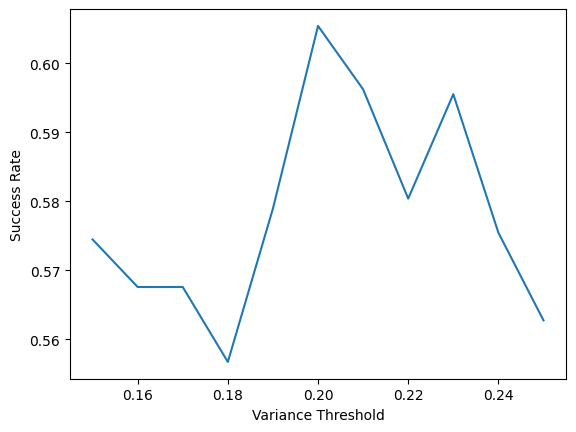

In [ ]:
#Plot a graph to see which variance yield the highest rate of success. We see that the best variance is 0.21 in terms of success rate
plt.ylabel("Success Rate")
plt.xlabel("Variance Threshold")
plt.plot(var_th, sr)
plt.show()

# Optimization Model w/ the Optimal Variance
We will now apply the optimization model with the best variance for the highest success rate to see the best results. We see that with a success rate of almost 61%, we get a return of of almost 16%! This is a relatively significant improvement and pretty solid results.

In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

[0.5773846153846154, 0.42261538461538456, 0.7141119767745154, 0.2858880232254845, 0.714906535490823, 0.28509346450917705, 0.43948513046093696, 0.560514869539063, 0.7029179859078647, 0.29708201409213525, 0.5754156314699794, 0.42458436853002063, 0.5225283094098884, 0.47747169059011163, 0.7488868504288186, 0.2511131495711814, 0.572463983630355, 0.42753601636964506, 0.5210679481475885, 0.4789320518524115, 0.5705922077922078, 0.4294077922077922, 0.54294708994709, 0.45705291005291004, 0.8479205586080587, 0.15207944139194138, 0.7034200608473052, 0.29657993915269454, 0.6281073338426278, 0.3718926661573721, 0.8252014652014652, 0.17479853479853477, 0.715, 0.285, 0.41466254284829923, 0.5853374571517007, 0.7029982641472001, 0.29700173585279965, 0.8687057808455565, 0.13129421915444348, 0.6682271106081206, 0.33177288939187954, 0.7416175495633328, 0.2583824504366673, 0.6491679197994986, 0.3508320802005012, 0.5425517548761222, 0.4574482451238779, 0.6564871198079029, 0.343512880192097, 0.80617696148244

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 29 times so far.

  warnings.warn(msg, UserWarning)


[0. 0. 0. ... 0. 1. 0.]
money bet = 147
profit = 22.99000000000001
successes = 89
failures = 58
don't bet = 453
Success percentage: 0.6054421768707483
return = 0.1563945578231293


# Cumulative Profits over the Weeks
Now that we optimized our model, it would be interesting to know how much profit is made throughout the 14 weeks and see the trend.

In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 45 times so far.

  warnings.warn(msg, UserWarning)


money bet = 147
profit = 29.540149355829097
successes = 89
failures = 58
don't bet = 453
Success percentage: 0.6054421768707483
return = 0.20095339697842923
[0, 9.01, 3.8239833333333326, 8.026235714285715, 7.552987836734695, 7.079739959183675, 3.9773372063492074, 19.292164354875293, 26.479209602165007, 32.71484294734855, 21.821362429142916, 32.55493864616389, 29.286109246366024, 26.220172705865956, 27.865859231281433]


 We see a steady increase throughout the weeks with small dips in profits occurring in a few weeks. I guess we get a better idea of which weeks we should bet and which weeks we shouldn't.

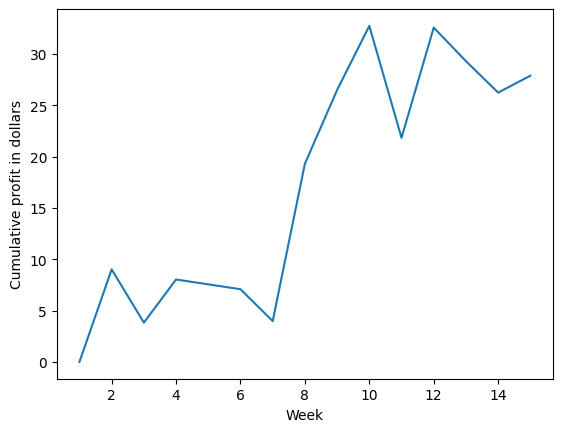

In [ ]:
plt.plot(weeks, continuous_profit)
plt.ylabel("Cumulative profit in dollars")
plt.xlabel("Week")
plt.show()

# Weekly scenario
We ran the model but this time we see what the returns would look like if we bet every week with a starting wager of 100 dollars, and then continuously bet our winnings every week. For example, if we bet 100 dollars on week 1 and win 20 dollars back, we will bet 120 dollars on week 2. Since we are testing this on 600 games, we will assume that there are 42 games per week.

In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 31 times so far.

  warnings.warn(msg, UserWarning)


Betting result per game: ['N', 'N', 'S', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'S', 'F', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'N', 'S', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'S', 'N', 'S', 'F', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'S', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'F', 'S', 'N', 'F', 'S', 'N', 'N', 'N', 'N', 'S', 'S', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'F', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'S', 'N', 'N', 'F', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'F', 'N', 'S', 'N',

It's pretty cool to see that on a weekly basis, we tend to make profit most of the times. Even though it is just a couple of dollars, the model is right more than 60% of the times and for this example, we get a return of ~58% of our money. These results are relatively too good, and testing it on a dataset it hasn't been trained on will determine its performance.

## Predicting 2019 Data
Now that we ran our model on a dataset it's been trained on, it's time to put  it to the real test and run it on the 2019 College Football season.

In [ ]:
df2019 = pd.read_csv("{}/19_data.csv".format(data_dir))
df2019.head()

,Date,Week,T1 VH,T1 Ranked,T1 Name,T1 ML,T1 Open,T1 Close,T1 Move,T1 Win %,...,T2 Cover %,T2 Over %,O/U Open,O/U Close,O/U Move,T1 Final,T2 Final,O/U,ML,Cover
0,824,0,0.0,1,Florida,-310,-8.5,-7.0,1.5,0.0,...,0.0,0.0,49.0,46.0,-3.0,24,20,0,1,0
1,824,0,0.0,0,Arizona,-400,-12.0,-10.5,1.5,0.0,...,0.0,0.0,71.0,71.0,0.0,38,45,1,0,0
2,824,0,1.0,0,Colgate,-270,-4.0,-7.0,-3.0,0.0,...,0.0,0.0,34.5,35.0,0.5,14,34,1,0,0
3,824,0,0.0,0,YoungstownSt,-260,-4.0,-6.5,-2.5,0.0,...,0.0,0.0,52.5,49.0,-3.5,45,22,1,1,1
4,829,1,1.0,0,CincinnatiU,-135,-4.0,-2.5,1.5,0.0,...,0.0,0.0,62.0,55.5,-6.5,24,14,0,1,1


In [ ]:
from sklearn.model_selection import train_test_split
columns_to_drop = ['T1 Final ', 'T2 Final', 'O/U', 'ML', 'T1 Name', 'T1 Move', 'T2 Name', 'T2 Move', 'Date', 'O/U Open', 'O/U Close', 'O/U Move']

df2019 = df2019.drop(columns=columns_to_drop)


x_test2019 = df2019.drop('Cover',1)
y_test2019 = df2019['Cover']


<ipython-input-23-9d4751a6f7bf>:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x_test2019 = df2019.drop('Cover',1)


In [ ]:
x_test2019

,Week,T1 VH,T1 Ranked,T1 ML,T1 Open,T1 Close,T1 Win %,T1 Cover %,T1 Over %,T2 VH,T2 Ranked,T2 ML,T2 Open,T2 Close,T2 Win %,T2 Cover %,T2 Over %
0,0,0.0,1,-310,-8.5,-7.0,0.000000,0.000000,0.000000,1.0,0,250,8.5,7.0,0.0,0.000000,0.000000
1,0,0.0,0,-400,-12.0,-10.5,0.000000,0.000000,0.000000,1.0,0,300,12.0,10.5,0.0,0.000000,0.000000
2,0,1.0,0,-270,-4.0,-7.0,0.000000,0.000000,0.000000,0.0,0,230,4.0,7.0,0.0,0.000000,0.000000
3,0,0.0,0,-260,-4.0,-6.5,0.000000,0.000000,0.000000,1.0,0,220,4.0,6.5,0.0,0.000000,0.000000
4,1,1.0,0,-135,-4.0,-2.5,0.000000,0.000000,0.000000,0.0,0,115,4.0,2.5,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,13,0.0,0,-1400,-17.5,-21.0,0.400000,0.222222,0.555556,1.0,0,925,17.5,21.0,0.3,0.222222,0.222222
582,13,1.0,0,-170,-4.5,-3.5,0.444444,0.625000,0.750000,0.0,0,150,4.5,3.5,0.5,0.444444,0.666667
583,13,1.0,0,-360,-7.0,-10.0,0.555556,0.500000,0.750000,0.0,0,300,7.0,10.0,0.6,0.444444,0.666667
584,13,1.0,0,-8000,-30.5,-28.5,0.600000,0.666667,0.444444,0.0,0,3375,30.5,28.5,0.0,0.000000,0.500000


In [ ]:
y_test2019

0      0
1      0
2      0
3      1
4      1
      ..
581    1
582    0
583    1
584    0
585    1
Name: Cover, Length: 586, dtype: int64

In [ ]:
#Generate predictions and probabilities for each data point in the x_test2019 dataset
x_indices2019 = list(x_test2019.index.values)
print(len(x_indices2019))
pr2019 = []
pred2019 = []
#for i in range(len(x_indices)):
for i in range(0,len((x_indices2019))):
  c = clf.predict_proba([x_test2019.loc[x_indices2019[i]]])[0][1]
  n = clf.predict_proba([x_test2019.loc[x_indices2019[i]]])[0][0]
  pred2019.append(clf.predict([x_test2019.loc[x_indices2019[i]]])[0])

  pr2019.append(c)
  pr2019.append(n)
print(pr2019)
print(len(pr2019))
print(pred2019)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

586


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

[0.7630909090909092, 0.23690909090909087, 0.6030264588352824, 0.39697354116471767, 0.6874073426573426, 0.31259265734265734, 0.825, 0.175, 0.5415751879699249, 0.4584248120300752, 0.3128205128205128, 0.6871794871794872, 0.35079235968709654, 0.6492076403129035, 0.3128205128205128, 0.6871794871794872, 0.5932716406400617, 0.4067283593599384, 0.6989393939393939, 0.30106060606060603, 0.7709373735999123, 0.2290626264000877, 0.6556666666666666, 0.3443333333333334, 0.6785916603004839, 0.32140833969951615, 0.5472977537168714, 0.4527022462831286, 0.5906899908048439, 0.4093100091951561, 0.39686041115747, 0.6031395888425299, 0.607089303398127, 0.3929106966018731, 0.5006917875403868, 0.4993082124596133, 0.2928205128205128, 0.7071794871794872, 0.3128205128205128, 0.6871794871794872, 0.4397666445432623, 0.5602333554567377, 0.7419047539570685, 0.2580952460429317, 0.6083739416321384, 0.39162605836786163, 0.8034158361246597, 0.19658416387534036, 0.6852014652014653, 0.3147985347985348, 0.26477272727272727,

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X

In [ ]:
#Store target variable
y_list2019 = []
for i in range(0,len(x_indices2019)):
  y_list2019.append(y_test2019.loc[x_indices2019[i]])
print(y_list2019)

[0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 

In [ ]:
#Get Variances for 2019

#Initialize an empty list to store variances
variances_2019 = []

#Loop through the data points in the testing dataset for the year 2019
for data_point_index_2019 in list(x_test2019.index.values):
    #Initialize an empty list to store predictions from individual decision trees
    individual_tree_predictions_2019 = []

    #Initialize a variable to calculate the sum of individual tree predictions for 2019
    prediction_sum_2019 = 0

    #Iterate through the first 49 decision trees in the Random Forest
    for tree_index_2019 in range(0, 49):
        # Make a prediction using the current decision tree for the current data point in 2019
        tree_prediction_2019 = clf.estimators_[tree_index_2019].predict([x_test2019.loc[data_point_index_2019]])

        #Append the prediction to the list of individual tree predictions for 2019
        individual_tree_predictions_2019.append(tree_prediction_2019)

        #Add the prediction to the sum for 2019
        prediction_sum_2019 += tree_prediction_2019

    #Calculate the mean prediction across all 50 decision trees for 2019
    mean_prediction_2019 = prediction_sum_2019 / 50

    #Initialize a variable to calculate the variance for 2019
    variance_2019 = 0

    #Iterate through the first 49 decision trees again for 2019
    for tree_index_2019 in range(0, 49):
        #Calculate the squared difference between the current tree's prediction and the mean prediction for 2019, and add it to the variance for 2019
        squared_difference_2019 = (individual_tree_predictions_2019[tree_index_2019] - mean_prediction_2019) ** 2
        variance_2019 += squared_difference_2019

    #Calculate the final variance for 2019 by dividing by the number of trees minus 1
    variance_2019 /= 49

    #Append the calculated variance for 2019 to the list of variances
    variances_2019.append(variance_2019[0])

print("Total variances calculated for 2019:", len(variances_2019))
print("Variance for the first data point in 2019:", variances_2019[0])


Total variances calculated for 2019: 586
Variance for the first data point in 2019: 0.16268571428571427


# Optimization Model
Although the success rate and the return did go down, we still see that the model's picks yield a profit. They also didnt go down significantly, suggesting that the model performs well on data it hasn't been trained on.

In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 32 times so far.

  warnings.warn(msg, UserWarning)


[1. 0. 0. ... 0. 0. 0.]
['F', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'F', 'N', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'S', 'N', 'N', 'F', 'N', 'S', 'N', 'N', 'F', 'N', 'F', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'F', 'N', 'S', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'N', 'F', 'F', 'S', 'S', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'F', 'N', 'F', 'N', 'N', 'F', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'F', 'N', 'N', 'S', 'S', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'F', 'F', 'N', 'N', 'S', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'F', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'S', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'S', 'F', 'N', 'N', 'N', 'N', 'S', 'F', 'N', 'N', 'F', 'S', 'S', 'N', 'N', 'N', 'N', 'N', 'S', 'N', 'N', 'N', 'N', 

# Cumulative Profits over the Weeks
Again, we see a steady increase throughout the weeks with small dips in profits occurring in some weeks.

In [ ]:
#Code is not shown to maintain confidentiality and competitive advantage.

/usr/local/lib/python3.10/dist-packages/cvxpy/expressions/expression.py:612: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 33 times so far.

  warnings.warn(msg, UserWarning)


money bet = 118
profit = 13.207811242988441
successes = 68
failures = 50
don't bet = 468
Success percentage: 0.576271186440678
return = 0.11193060375413934
[0, 1.3700000000000006, 0.7208200000000011, 2.03978888888889, 5.706540719012347, 10.693751819947547, 10.243008365387967, 11.157015926022671, 12.900171636053733, 15.168397513981756, 14.555714304296343, 12.826586134739733, 9.73593972143776, 13.207811242988434]


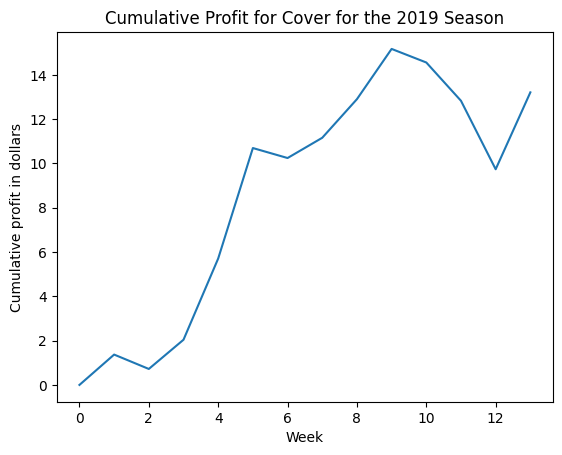

In [ ]:
plt.plot(weeks, continuous_profit)
plt.ylabel("Cumulative profit in dollars")
plt.title("Cumulative Profit for Cover for the 2019 Season")
plt.xlabel("Week")
plt.show()


## Conclusion and Future Steps
Overall, we were able to successfully create a system that can accurately forecast the results of future college football games, i.e. predicting the point spread. This predictive capability has the potential to inform profitable wagering decisions. Our next step would be to run this on more datasets (i.e. 2020, 2021, 2022 and even the ongoing 2023 seasons) to see how well the model continues to perform, and get a stronger sense of its capabilities.